## Load the NIST data into a dictionary

In [1]:
import os
import json

def load_json_files(directory):
    cve_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), "r") as file:
                data = json.load(file)
                vulnerabilities = data.get("vulnerabilities", [])
                for vulnerability in vulnerabilities:
                    if vulnerability["cve"]["id"] not in cve_dict.keys():
                        cve_id = vulnerability["cve"]["id"]
                        cve_dict[cve_id] = vulnerability["cve"]
    return cve_dict

directory = "../2024_Data/NIST_2024"
cve_dictionary = load_json_files(directory)
print("Loaded {} CVEs into the dictionary.".format(len(cve_dictionary)))


Loaded 249088 CVEs into the dictionary.


## Functions for fetching CVEs based on chipsets and Android versions

In [2]:
import os
import pandas as pd
from tqdm import tqdm

chipset_cves_dir = '../2024_Data/chipset_cves'
version_cves_dir = '../2024_Data/android_version_cves'

def process_cve_file(cve_data, last_update_date, cve_dictionary):
    all_cves = set()
    exploit_quarter = {f'exploit_q{i+1}': set() for i in range(len(ranges))}
    
    for cve in cve_data['cve']:
        if cve in cve_dictionary:
            published_date = pd.to_datetime(cve_dictionary[cve]['published'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
            # print(f'{last_update_date} vs {published_date}')
            if last_update_date <= published_date:
                all_cves.add(cve)
                pre_exploit_window = (published_date - last_update_date).days
                for i, (start, end) in enumerate(ranges):
                    if (pre_exploit_window < end) & (pre_exploit_window >= start):
                        exploit_quarter[f'exploit_q{i+1}'].add(cve)
    
    return all_cves, exploit_quarter

def get_cves(unpatched_data, vendor, cve_dictionary):
    unpatched_data['keyword'] = unpatched_data['keyword'].astype(str)
    unpatched_data['last_android_version'] = unpatched_data['last_android_version'].astype(str)

    # Define the quarterly ranges
    global ranges
    ranges = [(i * 90, (i + 1) * 90) for i in range(30)]

    # Initialize columns for quarterly CVEs and max quarter count
    for i in range(len(ranges)):
        unpatched_data[f'exploit_q{i+1}'] = ''
    unpatched_data['max_exploit_quarter'] = 0

    # Iterate through each row in unpatched_data using tqdm
    for index, row in tqdm(unpatched_data.iterrows(), total=len(unpatched_data), desc=f'Processing {vendor}...'):
        last_update_date = row['last_update_date']
        all_cves = set()
        chipset_cves = set()
        version_cves = set()
        exploit_quarter = {f'exploit_q{i+1}': set() for i in range(len(ranges))}

        keywords = row['keyword'].split(',')
        # print('keywords:', keywords)
        for keyword in keywords:
            keyword = keyword.replace(' ', '_')
            # print('Processing keyword:', keyword)
            chipset_filename = os.path.join(chipset_cves_dir, f'{keyword}.csv')
            if os.path.isfile(chipset_filename):
                chipset_cve_data = pd.read_csv(chipset_filename)
                if chipset_cve_data.empty:
                    print(f"File {chipset_filename} is empty.")
                cves, quarters = process_cve_file(chipset_cve_data, last_update_date, cve_dictionary)
                all_cves.update(cves)
                chipset_cves.update(cves)
                for key in quarters:
                    exploit_quarter[key].update(quarters[key])
        
        last_android_version = row['last_android_version'].replace(' ', '_')
        version_filename = os.path.join(version_cves_dir, f'{last_android_version}.csv')
        if os.path.isfile(version_filename):
            version_cve_data = pd.read_csv(version_filename)
            cves, quarters = process_cve_file(version_cve_data, last_update_date, cve_dictionary)
            all_cves.update(cves)
            version_cves.update(cves)
            for key in quarters:
                exploit_quarter[key].update(quarters[key])

        for i in range(len(ranges)):
            unpatched_data.at[index, f'exploit_q{i+1}'] = ', '.join(exploit_quarter[f'exploit_q{i+1}'])

        unpatched_data.at[index, 'num_chipset_cves'] = len(chipset_cves)
        unpatched_data.at[index, 'num_version_cves'] = len(version_cves)
        unpatched_data.at[index, 'num_cves'] = len(all_cves)
        unpatched_data.at[index, 'all_cves'] = ', '.join(all_cves)

        # Calculate max quarter count
        days_after_eol_max = max([(pd.to_datetime(cve_dictionary[cve]['published'], format='%Y-%m-%dT%H:%M:%S.%f') - last_update_date).days for cve in all_cves], default=0)
        unpatched_data.at[index, 'max_exploit_quarter'] = round(days_after_eol_max / 90)
    
    output_path = os.path.join('../2024_Data', vendor, f'{vendor}_with_cves.csv')
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    unpatched_data.to_csv(output_path, index=False)
    
    return unpatched_data


In [18]:
from collections import Counter
import pandas as pd

def convert_cvss_v2_to_v3(cvss_v2_score):
    if cvss_v2_score == 0.0:
        return 'none'
    elif 0.1 <= cvss_v2_score <= 3.9:
        return 'low'
    elif 4.0 <= cvss_v2_score <= 6.9:
        return 'medium'
    elif 7.0 <= cvss_v2_score <= 8.9:
        return 'high'
    elif 9.0 <= cvss_v2_score <= 10.0:
        return 'critical'
    else:
        return 'invalid cvssv2 score'

def get_baseSeverity(metrics):
    try:
        if 'cvssMetricV31' in metrics:
            return metrics['cvssMetricV31'][0]['cvssData']['baseSeverity'].lower()
        elif 'cvssMetricV30' in metrics:
            return metrics['cvssMetricV30'][0]['cvssData']['baseSeverity'].lower()
        elif 'cvssMetricV2' in metrics:
            v2_score = metrics['cvssMetricV2'][0]['cvssData']['baseScore']
            v3_severity = convert_cvss_v2_to_v3(v2_score)
            return v3_severity
        else:
            return 'not found'
    except (KeyError, IndexError, TypeError):
        return 'not found'

def get_userInteraction(metrics):
    try:
        if 'cvssMetricV31' in metrics:
            return metrics['cvssMetricV31'][0]['cvssData']['userInteraction'].lower()
        elif 'cvssMetricV30' in metrics:
            return metrics['cvssMetricV30'][0]['cvssData']['userInteraction'].lower()
        elif 'cvssMetricV2' in metrics:
            result = metrics['cvssMetricV2'][0]['userInteractionRequired']
            return 'none' if result == False else 'required'
        else:
            return 'not found'
    except (KeyError, IndexError, TypeError):
        return 'not found'


def get_attackComplexity(metrics):
    try:
        if 'cvssMetricV31' in metrics:
            return metrics['cvssMetricV31'][0]['cvssData']['attackComplexity'].lower()
        elif 'cvssMetricV30' in metrics:
            return metrics['cvssMetricV30'][0]['cvssData']['attackComplexity'].lower()
        elif 'cvssMetricV2' in metrics:
            return metrics['cvssMetricV2'][0]['cvssData']['accessComplexity'].lower()
        else:
            return 'not found'
    except (KeyError, IndexError, TypeError):
        return 'not found'

def get_attackVector(metrics):
    try:
        if 'cvssMetricV31' in metrics:
            return metrics['cvssMetricV31'][0]['cvssData']['attackVector'].lower()
        elif 'cvssMetricV30' in metrics:
            return metrics['cvssMetricV30'][0]['cvssData']['attackVector'].lower()
        elif 'cvssMetricV2' in metrics:
            return metrics['cvssMetricV2'][0]['cvssData']['accessVector'].lower()
        else:
            return 'not found'
    except (KeyError, IndexError, TypeError):
        return 'not found'

## Load Unpatched Device Data

In [3]:
import pandas as pd

# Read the CSV files into dataframes
pixel_unpatched = pd.read_csv('../2024_Data/pixel/pixel_unpatched_with_chipsets.csv')
xiaomi_unpatched = pd.read_csv('../2024_Data/xiaomi/xiaomi_unpatched_with_chipsets.csv')
oppo_unpatched = pd.read_csv('../2024_Data/oppo/oppo_unpatched_with_chipsets.csv')
samsung_unpatched = pd.read_csv('../2024_Data/samsung/samsung_unpatched_with_chipsets.csv')
lg_unpatched = pd.read_csv('../2024_Data/lg/lg_unpatched_with_chipsets.csv')
vivo_unpatched = pd.read_csv('../2024_Data/vivo/vivo_unpatched_with_chipsets.csv')


print('=== Statistics of unpatched devices per OEM ===')
print('Unique devices of Pixel: {}'.format(len(pixel_unpatched['device'].unique())))
print('Unique devices of Xiaomi: {}'.format(len(xiaomi_unpatched['device'].unique())))
print('Unique devices of Oppo: {}'.format(len(oppo_unpatched['device'].unique())))
print('Unique devices of Samsung: {}'.format(len(samsung_unpatched['device'].unique())))
print('Unique devices of LG: {}'.format(len(lg_unpatched['device'].unique())))
print('Unique devices of Vivo: {}'.format(len(vivo_unpatched['device'].unique())))
print()
print('Total devices of Pixel: {}'.format(len(pixel_unpatched['id'])))
print('Total devices of Xiaomi: {}'.format(len(xiaomi_unpatched['id'])))
print('Total devices of Oppo: {}'.format(len(oppo_unpatched['id'])))
print('Total devices of Samsung: {}'.format(len(samsung_unpatched['id'])))
print('Total devices of LG: {}'.format(len(lg_unpatched['id'])))
print('Total devices of Vivo: {}'.format(len(vivo_unpatched['id'])))

=== Statistics of unpatched devices per OEM ===
Unique devices of Pixel: 26
Unique devices of Xiaomi: 326
Unique devices of Oppo: 77
Unique devices of Samsung: 377
Unique devices of LG: 13
Unique devices of Vivo: 71

Total devices of Pixel: 26
Total devices of Xiaomi: 902
Total devices of Oppo: 1183
Total devices of Samsung: 24916
Total devices of LG: 36
Total devices of Vivo: 286


In [4]:
# Add a vendor column to each dataframe
pixel_unpatched['vendor'] = 'Pixel'
xiaomi_unpatched['vendor'] = 'Xiaomi'
oppo_unpatched['vendor'] = 'Oppo'
samsung_unpatched['vendor'] = 'Samsung'
lg_unpatched['vendor'] = 'LG'
vivo_unpatched['vendor'] = 'Vivo'

pixel_unpatched['last_update_date'] = pd.to_datetime(pixel_unpatched['last_update_date'])
xiaomi_unpatched['last_update_date'] = pd.to_datetime(xiaomi_unpatched['last_update_date'], format='%m/%d/%y')
oppo_unpatched['last_update_date'] = pd.to_datetime(oppo_unpatched['last_update_date'], format='%m/%d/%y')
samsung_unpatched['last_update_date'] = pd.to_datetime(samsung_unpatched['last_update_date'])
lg_unpatched['last_update_date'] = pd.to_datetime(lg_unpatched['last_update_date'])
vivo_unpatched['last_update_date'] = pd.to_datetime(vivo_unpatched['last_update_date'])

## Get CVEs for each unpatched device

In [6]:
xiaomi_with_cves = get_cves(xiaomi_unpatched, 'xiaomi', cve_dictionary)
samsung_with_cves = get_cves(samsung_unpatched, 'samsung', cve_dictionary)
oppo_with_cves = get_cves(oppo_unpatched, 'oppo', cve_dictionary)
pixel_with_cves = get_cves(pixel_unpatched, 'pixel', cve_dictionary)
lg_with_cves = get_cves(lg_unpatched, 'lg', cve_dictionary)
vivo_with_cves = get_cves(vivo_unpatched, 'vivo', cve_dictionary)

Processing vivo...: 100%|████████████████████| 286/286 [00:40<00:00,  7.04it/s]


In [7]:
all_unpatched = pd.concat([xiaomi_with_cves, samsung_with_cves, oppo_with_cves, pixel_with_cves, lg_with_cves, vivo_with_cves], ignore_index=True)

all_unpatched.to_csv('../2024_Data/all_unpatched_cves.csv', index=False)
all_unpatched.head()

,id,device,last_android_version,last_update_date,chipset,keyword,vendor,exploit_q1,exploit_q2,exploit_q3,...,exploit_q29,exploit_q30,max_exploit_quarter,num_chipset_cves,num_version_cves,num_cves,all_cves,country,region,device_name
0,mione_plus,mi 1s,Android 4.1,2015-04-12,Qualcomm MSM8260,qualcomm msm8260,Xiaomi,"CVE-2015-3107, CVE-2015-3100, CVE-2015-3096, C...","CVE-2015-3827, CVE-2015-7717, CVE-2015-5575, C...","CVE-2015-8423, CVE-2015-8063, CVE-2015-7634, C...",...,CVE-2013-10001,"CVE-2021-22131, CVE-2022-28755",36,0.0,1270.0,1270.0,"CVE-2015-3827, CVE-2015-8063, CVE-2016-2422, C...",NaN,NaN,NaN
1,taurus,mi 2a,Android 4.1,2015-04-27,Snapdragon S4 Pro,snapdragon s4 pro,Xiaomi,"CVE-2015-3107, CVE-2015-3100, CVE-2015-3096, C...","CVE-2015-3827, CVE-2015-7717, CVE-2015-5575, C...","CVE-2015-8413, CVE-2015-8404, CVE-2015-8414, C...",...,CVE-2013-10001,"CVE-2021-22131, CVE-2022-28755",36,0.0,1270.0,1270.0,"CVE-2015-3827, CVE-2015-8063, CVE-2016-2422, C...",NaN,NaN,NaN
2,HM2013022,redmi 1 td,Android 4.4,2017-11-15,Qualcomm MSM8228 Snapdragon 400 (28 nm),"qualcomm msm8228,snapdragon 400",Xiaomi,"CVE-2017-0864, CVE-2017-0863, CVE-2017-0843, C...","CVE-2017-7375, CVE-2013-6272, CVE-2017-7376, C...","CVE-2018-11304, CVE-2018-5907, CVE-2017-7817",...,,,25,0.0,219.0,219.0,"CVE-2023-21316, CVE-2017-18664, CVE-2015-9547,...",NaN,NaN,NaN
3,HM2014813,redmi 2 lte,Android 4.4,2015-03-29,"Qualcomm MSM8916,Snapdragon 410 (28 nm)","qualcomm msm8916,snapdragon 410",Xiaomi,"CVE-2015-3107, CVE-2015-3100, CVE-2015-3096, C...","CVE-2015-5575, CVE-2015-5580, CVE-2015-5582, C...","CVE-2015-3827, CVE-2015-8423, CVE-2015-1541, C...",...,"CVE-2022-23729, CVE-2021-44166, CVE-2021-35105...","CVE-2022-22087, CVE-2022-22085, CVE-2021-35072...",36,418.0,1320.0,1738.0,"CVE-2015-3827, CVE-2019-10483, CVE-2015-8063, ...",NaN,NaN,NaN
4,HM2013023_sg_global,redmi 1 w,Android 4.4,2015-12-24,Qualcomm MSM8228 Snapdragon 400 (28 nm),"qualcomm msm8228,snapdragon 400",Xiaomi,"CVE-2016-0805, CVE-2015-8639, CVE-2015-6645, C...","CVE-2016-2107, CVE-2016-2469, CVE-2016-2474, C...","CVE-2014-9872, CVE-2014-9891, CVE-2014-9879, C...",...,"CVE-2022-39912, CVE-2022-36928, CVE-2022-39914...","CVE-2023-22881, CVE-2021-26277, CVE-2023-28597...",33,0.0,1089.0,1089.0,"CVE-2016-2422, CVE-2014-9962, CVE-2014-9883, C...",NaN,NaN,NaN


In [8]:
unique_cves = set()

for i in tqdm(range(1, 31), desc="Processing Quarters"): 
    q = 'exploit_q'+str(i)
    for cves in all_unpatched[q]:
        if pd.notna(cves):
            cves_list = cves.split(', ')
            for cve in cves_list:
                unique_cves.add(cve)

print('Total unique CVEs assigned to devices:', len(unique_cves))

Processing Quarters: 100%|█████████████████████| 30/30 [00:00<00:00, 30.01it/s]

Total unique CVEs assigned to devices: 7060


In [9]:
len(all_unpatched)

27349

In [10]:
len(all_unpatched[all_unpatched['max_exploit_quarter']>1]['id'].unique())

13974

In [11]:
len(all_unpatched[all_unpatched['max_exploit_quarter']>1]['device'].unique())

626

In [12]:
all_unpatched.groupby('vendor')['num_cves'].mean()

vendor
LG         852.305556
Oppo       827.501268
Pixel       45.615385
Samsung    280.287004
Vivo       911.667832
Xiaomi     378.485588
Name: num_cves, dtype: float64

In [13]:
all_unpatched[(all_unpatched['vendor']=='Samsung')&(all_unpatched['max_exploit_quarter']==3)]['device'].unique()[:50]

array(['galaxy a03', 'galaxy a04e', 'galaxy a10', 'galaxy a10e',
       'galaxy a10s', 'galaxy a14 5g', 'galaxy a20', 'galaxy a20s',
       'galaxy a23 5g', 'galaxy a30', 'galaxy a30s', 'galaxy a34 5g',
       'galaxy a40', 'galaxy a42 5g', 'galaxy a50', 'galaxy a50s',
       'galaxy a51', 'galaxy a60', 'galaxy a7', 'galaxy a70',
       'galaxy a70s', 'galaxy a8+', 'galaxy a80', 'galaxy j2 core',
       'galaxy j6', 'galaxy j7 (2017)', 'galaxy m30s', 'galaxy m40',
       'galaxy s10', 'galaxy s10 5g', 'galaxy s10 lite', 'galaxy s10+',
       'galaxy s10e', 'galaxy s20 fe', 'galaxy s6', 'galaxy s6 edge',
       'galaxy s6 edge+', 'galaxy tab a 10.1 (2019)', 'galaxy tab a7',
       'galaxy tab s4', 'galaxy tab s5e', 'galaxy xcover 4s',
       'galaxy watch4 40mm', 'galaxy watch4 44mm',
       'galaxy watch4 classic 42mm', 'galaxy watch4 classic 46mm',
       'galaxy watch5 40mm', 'galaxy watch5 44mm', 'galaxy watch5 pro'],
      dtype=object)

In [14]:
print(all_unpatched[all_unpatched['device'] == 'galaxy z fold3 5g']['max_exploit_quarter'].max())


8


## Analyze CWEs

In [15]:
# all_unpatched = pd.read_csv('../2024_Data/all_unpatched_cves.csv')


df_final = all_unpatched.copy()
df_final_v2 = df_final[df_final['num_cves']>0]

print('Total rows before:', len(all_unpatched))
print('Total rows after conditions:', len(df_final_v2))

Total rows before: 27349
Total rows after conditions: 16014


In [19]:
import pandas as pd
from tqdm import tqdm
from collections import Counter

def get_cwes(weaknesses):
    cwes = set()
    for weakness in weaknesses:
        if 'description' in weakness and weakness['description']:
            cwe = weakness['description'][0].get('value')
            if cwe:
                cwes.add(cwe)
    return list(cwes)

cwe_counts = {}
cwe_accumulated_counts_per_device = {}
d = []

# Accumulated sums
cve_per_pair_accumulated = 0
critical_per_pair_accumulated = 0
high_per_pair_accumulated = 0
medium_per_pair_accumulated = 0
low_per_pair_accumulated = 0
cwe_per_pair_accumulated = 0

print('{} unsupported devices'.format(len(df_final_v2.index)))

for i in tqdm(range(1, 31), desc="Processing Quarters"): 
    q = 'exploit_q'+str(i)
    
    cond1 = ~df_final[q].isnull()
    cond2 = df_final[q] != ''
    cond3 = df_final['max_exploit_quarter'] >= (i - 1)

    df_final_active = df_final[cond1 & cond2 & cond3]
    
    pair_count = len(df_final_active['id'].unique())
    
    quarter_cves = [cve.strip() for sublist in df_final_active[q].str.split(', ') for cve in sublist if cve.strip()]
    quarter_cves_unique = list(set(quarter_cves))

    # Compute CVE statistics as before
    total_cve_count = len(quarter_cves)
    unique_cve_count = len(quarter_cves_unique)
    
    cve_per_pair = total_cve_count / pair_count if pair_count != 0 else 0
    cve_per_pair_accumulated += cve_per_pair

    df_quarter = {key: cve_dictionary[key] for key in quarter_cves if key in cve_dictionary}
    df_quarter = pd.DataFrame.from_dict(df_quarter, orient='index')

    # Track CWEs found in this quarter
    current_quarter_cwes = []

    for cve in quarter_cves:
        if cve in df_quarter.index:
            weaknesses = df_quarter.loc[cve, 'weaknesses']
            if isinstance(weaknesses, list):
                cwes_list = get_cwes(weaknesses)
                for cwe in cwes_list:
                    current_quarter_cwes.append(cwe)

    total_cwe_count = len(current_quarter_cwes)
    unique_cwe_count = len(list(set(current_quarter_cwes)))
    cwe_per_pair = total_cwe_count / pair_count if pair_count != 0 else 0
    cwe_per_pair_accumulated += cwe_per_pair

    severity_levels = ['critical', 'high', 'medium', 'low']
    severity_counts = {level: 0 for level in severity_levels}
    
    counter_q_cves_all = Counter(quarter_cves)
    
    for level in severity_levels:
        severity_cves = df_quarter[df_quarter['metrics'].apply(get_baseSeverity) == level]['id'].tolist()
        severity_counts[level] = sum(counter_q_cves_all[cve] for cve in severity_cves)
    
    critical_count = severity_counts['critical']
    high_count = severity_counts['high']
    medium_count = severity_counts['medium']
    low_count = severity_counts['low']
    
    critical_per_pair = critical_count / pair_count if pair_count != 0 else 0
    high_per_pair = high_count / pair_count if pair_count != 0 else 0
    medium_per_pair = medium_count / pair_count if pair_count != 0 else 0
    low_per_pair = low_count / pair_count if pair_count != 0 else 0
    
    critical_per_pair_accumulated += critical_per_pair
    high_per_pair_accumulated += high_per_pair
    medium_per_pair_accumulated += medium_per_pair
    low_per_pair_accumulated += low_per_pair
    
    none_count = len(df_quarter[df_quarter['metrics'].apply(get_userInteraction) == 'none'])
    required_count = len(df_quarter[df_quarter['metrics'].apply(get_userInteraction) == 'required'])
    
    none_per = (none_count * 100) / (none_count + required_count) if (none_count + required_count) != 0 else 0
    required_per = (required_count * 100) / (none_count + required_count) if (none_count + required_count) != 0 else 0
    
    low_comp_count = len(df_quarter[df_quarter['metrics'].apply(get_attackComplexity) == 'low'])
    medium_comp_count = len(df_quarter[df_quarter['metrics'].apply(get_attackComplexity) == 'medium'])
    high_comp_count = len(df_quarter[df_quarter['metrics'].apply(get_attackComplexity) == 'high'])
    
    low_comp_per = (low_comp_count * 100) / (low_comp_count + medium_comp_count + high_comp_count) if (low_comp_count + medium_comp_count + high_comp_count) != 0 else 0
    medium_comp_per = (medium_comp_count * 100) / (low_comp_count + medium_comp_count + high_comp_count) if (low_comp_count + medium_comp_count + high_comp_count) != 0 else 0
    high_comp_per = (high_comp_count * 100) / (low_comp_count + medium_comp_count + high_comp_count) if (low_comp_count + medium_comp_count + high_comp_count) != 0 else 0
    
    local_count = len(df_quarter[df_quarter['metrics'].apply(get_attackVector) == 'local'])
    adjacent_network_count = len(df_quarter[df_quarter['metrics'].apply(get_attackVector) == 'adjacent_network'])
    network_count = len(df_quarter[df_quarter['metrics'].apply(get_attackVector) == 'network'])
    physical_count = len(df_quarter[df_quarter['metrics'].apply(get_attackVector) == 'physical'])
    
    local_per = (local_count * 100) / (local_count + adjacent_network_count + network_count + physical_count) if (local_count + adjacent_network_count + network_count + physical_count) != 0 else 0
    adjacent_network_per = (adjacent_network_count * 100) / (local_count + adjacent_network_count + network_count + physical_count) if (local_count + adjacent_network_count + network_count + physical_count) != 0 else 0
    network_per = (network_count * 100) / (local_count + adjacent_network_count + network_count + physical_count) if (local_count + adjacent_network_count + network_count + physical_count) != 0 else 0
    physical_per = (physical_count * 100) / (local_count + adjacent_network_count + network_count + physical_count) if (local_count + adjacent_network_count + network_count + physical_count) != 0 else 0
    
    none_critical_count = len(df_quarter[(df_quarter['metrics'].apply(get_userInteraction) == 'none') & (df_quarter['metrics'].apply(get_baseSeverity) == 'critical')])
    none_critical_count_per = (none_critical_count * 100) / (none_count + required_count) if (none_count + required_count) != 0 else 0
    
    none_high_count = len(df_quarter[(df_quarter['metrics'].apply(get_userInteraction) == 'none') & (df_quarter['metrics'].apply(get_baseSeverity) == 'high')])
    none_high_count_per = (none_high_count * 100) / (none_count + required_count) if (none_count + required_count) != 0 else 0
    
    d.append({
        'period': i,
        'total_cve_count': total_cve_count,
        'unique_cve_count': unique_cve_count,
        'pair_count': pair_count,
        'cve_per_pair': cve_per_pair,
        'cve_per_pair_accumulated': cve_per_pair_accumulated,
        'critical_count': critical_count,
        'high_count': high_count,
        'medium_count': medium_count,
        'low_count': low_count,
        'critical_per_pair': critical_per_pair,
        'high_per_pair': high_per_pair,
        'medium_per_pair': medium_per_pair,
        'low_per_pair': low_per_pair,
        'critical_per_pair_accumulated': critical_per_pair_accumulated,
        'high_per_pair_accumulated': high_per_pair_accumulated,
        'medium_per_pair_accumulated': medium_per_pair_accumulated,
        'low_per_pair_accumulated': low_per_pair_accumulated,
        'none_count': none_count,
        'required_count': required_count,
        'none_per': none_per,
        'required_per': required_per,
        'low_comp_count': low_comp_count,
        'medium_comp_count': medium_comp_count,
        'high_comp_count': high_comp_count,
        'low_comp_per': low_comp_per,
        'medium_comp_per': medium_comp_per,
        'high_comp_per': high_comp_per,
        'local_count': local_count,
        'adjacent_network_count': adjacent_network_count,
        'network_count': network_count,
        'physical_count': physical_count,
        'local_per': local_per,
        'adjacent_network_per': adjacent_network_per,
        'network_per': network_per,
        'physical_per': physical_per,
        'none_critical_count': none_critical_count,
        'none_critical_count_per': none_critical_count_per,
        'none_high_count': none_high_count,
        'none_high_count_per': none_high_count_per,
        'total_cwe_count': total_cwe_count,
        'unique_cwe_count': unique_cwe_count,
        'cwe_per_pair': cwe_per_pair,
        'cwe_per_pair_accumulated': cwe_per_pair_accumulated
    })

# Create DataFrame for the results
df_quarters = pd.DataFrame(d)

df_quarters.to_excel('../2024_Data/cve_cwe_analysis.xlsx', index=False)
df_quarters.head(20)

16014 unsupported devices


Processing Quarters: 100%|█████████████████████| 30/30 [00:30<00:00,  1.01s/it]


,period,total_cve_count,unique_cve_count,pair_count,cve_per_pair,cve_per_pair_accumulated,critical_count,high_count,medium_count,low_count,...,network_per,physical_per,none_critical_count,none_critical_count_per,none_high_count,none_high_count_per,total_cwe_count,unique_cwe_count,cwe_per_pair,cwe_per_pair_accumulated
0,1,1638065,5851,14296,114.582051,114.582051,56175,503570,988760,89560,...,25.978465,1.982567,705,12.049222,1876,32.062895,1847858,156,129.256995,129.256995
1,2,1555230,5726,12958,120.020837,234.602887,47890,435514,987131,84695,...,28.239609,1.921062,677,11.823262,1824,31.854698,1729755,150,133.489350,262.746345
2,3,1334717,5513,12162,109.744861,344.347749,58492,403446,807911,64868,...,27.389806,1.977145,714,12.951206,1781,32.305460,1443944,151,118.725867,381.472213
3,4,1062131,5118,11938,88.970598,433.318347,69486,307754,643013,41878,...,26.611958,2.207894,521,10.179758,1715,33.509183,1148662,146,96.218965,477.691177
4,5,820882,4721,10463,78.455701,511.774048,41146,242085,501176,36475,...,24.465156,2.118195,538,11.395891,1563,33.107393,886600,148,84.736691,562.427868
5,6,466589,4637,8648,53.953400,565.727447,24477,155407,267156,19549,...,22.298900,2.070304,463,9.984904,1482,31.960319,514076,142,59.444496,621.872364
6,7,345910,4367,7430,46.555855,612.283302,24768,107097,194312,19733,...,23.746279,2.198305,491,11.243417,1411,32.310511,386231,141,51.982638,673.855002
7,8,292920,3758,5583,52.466416,664.749718,26850,89054,162767,14249,...,23.097392,1.862693,416,11.069718,1255,33.395423,324914,142,58.197027,732.052029
8,9,214980,3483,5423,39.642264,704.391982,12928,70898,121349,9805,...,22.796440,1.952340,355,10.192363,1234,35.429228,238861,137,44.045916,776.097945
9,10,190888,3186,4744,40.237774,744.629756,10843,68949,104400,6696,...,23.101067,2.165725,353,11.079724,1081,33.929692,206743,136,43.579890,819.677835


In [20]:
import pandas as pd
from tqdm import tqdm

def get_cwes(weaknesses):
    cwes = set()
    for weakness in weaknesses:
        if 'description' in weakness and weakness['description']:
            cwe = weakness['description'][0].get('value')
            if cwe:
                cwes.add(cwe)
    return list(cwes)

cwe_counts = {}
cwe_accumulated_counts_per_device = {}
all_cwes = []

# Check if df_final and cve_dictionary are defined
if 'df_final' not in globals():
    raise NameError("df_final is not defined")
if 'cve_dictionary' not in globals():
    raise NameError("cve_dictionary is not defined")

# Ensure necessary columns exist in df_final
required_columns = ['id', 'max_exploit_quarter'] + [f'exploit_q{i}' for i in range(1, 31)]
missing_columns = [col for col in required_columns if col not in df_final.columns]
if missing_columns:
    raise KeyError(f"Missing columns in df_final: {missing_columns}")

for i in tqdm(range(1, 31), desc="Processing quarters"):
    quarter = 'exploit_q' + str(i)

    cond1 = ~df_final[quarter].isnull()
    cond2 = df_final[quarter] != ''
    cond3 = df_final['max_exploit_quarter'] >= (i - 1)

    df_final_active = df_final[cond1 & cond2 & cond3]
    
    pair_count = len(df_final_active['id'].unique())
    
    quarter_cves = [cve.strip() for sublist in df_final_active[quarter].str.split(', ') for cve in sublist if cve.strip()]
    quarter_cves_unique = list(set(quarter_cves))

    if quarter_cves:
        df_quarter = {key: cve_dictionary[key] for key in quarter_cves if key in cve_dictionary}
        df_quarter = pd.DataFrame.from_dict(df_quarter, orient='index')
    else:
        df_quarter = pd.DataFrame()

    # Track CWEs found in this quarter
    current_quarter_cwes = []

    for cve in quarter_cves:
        if cve in df_quarter.index:
            weaknesses = df_quarter.loc[cve, 'weaknesses']
            if isinstance(weaknesses, list):
                cwes_list = get_cwes(weaknesses)
                for cwe in cwes_list:
                    current_quarter_cwes.append(cwe)
                    if cwe not in cwe_counts:
                        cwe_counts[cwe] = [0] * 30
                    cwe_counts[cwe][i - 1] += 1
            else:
                print(f"Warning: Weaknesses for {cve} are not in expected list format.")
        else:
            print(f"Warning: {cve} not found in DataFrame index.")


Processing quarters: 100%|█████████████████████| 30/30 [00:30<00:00,  1.02s/it]


In [21]:
all_cwes = []
total_counts_per_quarter = {}

for cwe, counts in cwe_counts.items():
    for idx, count in enumerate(counts):
        if idx == 0:
            accum_counts = count
        else:
            prev_accum_counts = next((entry['accum_counts'] for entry in all_cwes if entry['exploit_quarter'] == idx and entry['cwe'] == cwe), 0)
            accum_counts = count + prev_accum_counts
        
        all_cwes.append({
            'exploit_quarter': idx + 1, 
            'cwe': cwe, 
            'count': count,
            'accum_counts': accum_counts
        })
        
        # Update total counts per quarter
        if idx + 1 not in total_counts_per_quarter:
            total_counts_per_quarter[idx + 1] = count
        else:
            total_counts_per_quarter[idx + 1] += count

# Add ratio column to all_cwes
for entry in all_cwes:
    quarter = entry['exploit_quarter']
    cwe_count = entry['count']
    total_count = total_counts_per_quarter[quarter]
    
    if total_count != 0:
        ratio = (cwe_count * 100) / total_count
    else:
        ratio = 0
    entry['total_cwes'] = total_count
    entry['ratio'] = ratio
    if quarter == 1:
        entry['accum_ratio'] = ratio
    else:
        prev_quarter_entry = next((e for e in all_cwes if e['exploit_quarter'] == quarter - 1 and e['cwe'] == entry['cwe']), None)
        if prev_quarter_entry:
            prev_accum_ratio = prev_quarter_entry['accum_ratio']
        else:
            prev_accum_ratio = 0
        entry['accum_ratio'] = ratio + prev_accum_ratio

# Print results
print(f"\n{'Quarter': <10} {'CWE': <10} {'Count': <8} {'Total CWEs': <15} {'accum_counts': <15} {'Ratio (%)': <10} {'Accumulated Ratio (%)': <10}")
for entry in all_cwes:
    if entry['cwe'] == 'CWE-787':
        print(f"{entry['exploit_quarter']: <10} {entry['cwe']: <10} {entry['count']: <8} {entry['total_cwes']: <15} {entry['accum_counts']: <15} {entry['ratio']: <10.2f} {entry['accum_ratio']: <10.2f}")


Quarter    CWE        Count    Total CWEs      accum_counts    Ratio (%)  Accumulated Ratio (%)
1          CWE-787    308956   1847858         308956          16.72      16.72     
2          CWE-787    298140   1729755         607096          17.24      33.96     
3          CWE-787    237006   1443944         844102          16.41      50.37     
4          CWE-787    177283   1148662         1021385         15.43      65.80     
5          CWE-787    112543   886600          1133928         12.69      78.50     
6          CWE-787    80365    514076          1214293         15.63      94.13     
7          CWE-787    52587    386231          1266880         13.62      107.75    
8          CWE-787    45088    324914          1311968         13.88      121.62    
9          CWE-787    35882    238861          1347850         15.02      136.64    
10         CWE-787    29053    206743          1376903         14.05      150.70    
11         CWE-787    23150    159748          140005

In [22]:
unique_cwes = set(entry['cwe'] for entry in all_cwes)
print("Length of unique CWEs in all_cwes:", len(unique_cwes))

Length of unique CWEs in all_cwes: 167


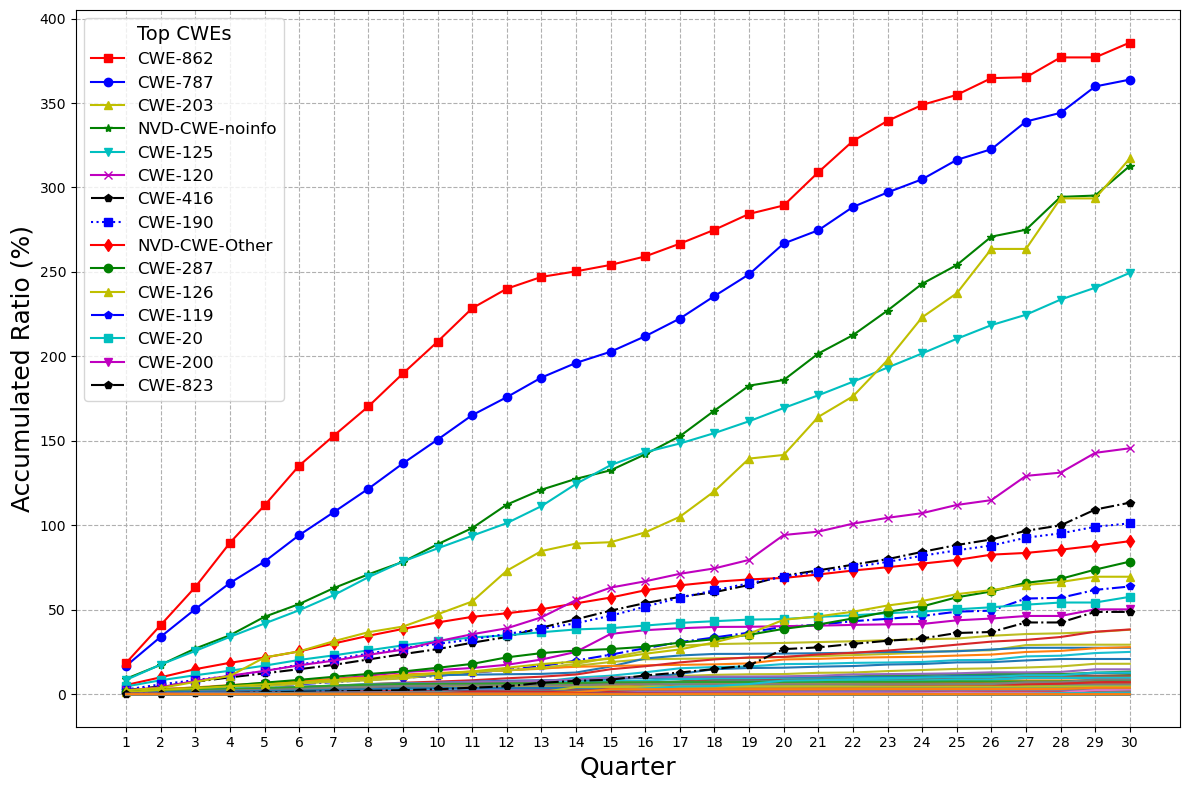

In [23]:
import matplotlib.pyplot as plt


cwe_data = {}
for entry in all_cwes:
    cwe = entry['cwe']
    if cwe not in cwe_data:
        cwe_data[cwe] = {'quarters': [], 'accum_ratios': []}
    cwe_data[cwe]['quarters'].append(entry['exploit_quarter'])
    cwe_data[cwe]['accum_ratios'].append(entry['accum_ratio'])

# Determine top 15 CWEs by the last accum_ratio value
top_cwes = sorted(cwe_data.keys(), key=lambda cwe: cwe_data[cwe]['accum_ratios'][-1], reverse=True)[:15]

# Define styles for top CWEs
styles = ['rs-', 'bo-', 'y^-', 'g*-',
          'cv-', 'mx-', 'kp-.', 'bs:',
          'rd-', 'go-', 'y^-', 'bp-.',
          'cs-', 'mv-', 'kp-.']
cwe_styles = {cwe: style for cwe, style in zip(top_cwes, styles)}

plt.figure(figsize=(12, 8))

for cwe, data in cwe_data.items():
    if cwe in top_cwes:
        style = cwe_styles[cwe]
    else:
        style = '-'  # Default style for other CWEs
    
    plt.plot(data['quarters'], data['accum_ratios'], style, label=None if cwe not in top_cwes else cwe)

# Customizing legend for top CWEs by the last accum_ratio value
handles, labels = plt.gca().get_legend_handles_labels()
sorted_labels = sorted(labels, key=lambda cwe: cwe_data[cwe]['accum_ratios'][-1], reverse=True)
sorted_handles = [handle for label, handle in sorted(zip(labels, handles), key=lambda pair: cwe_data[pair[0]]['accum_ratios'][-1], reverse=True)]

plt.legend(title='Top CWEs', handles=sorted_handles, labels=sorted_labels, loc='upper left', title_fontsize=14, fontsize=12)

plt.xlabel('Quarter', fontsize=18)
plt.ylabel('Accumulated Ratio (%)', fontsize=18)
plt.xticks(range(1, len(total_counts_per_quarter) + 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('../2024_Data/Figures/unsupported_top_cwes.png', bbox_inches='tight')

plt.show()


## Case Study: "Galaxy s10 5G"

In [24]:
df_galaxy_s10_5g = all_unpatched[(all_unpatched['device']=='galaxy s10 5g')&(all_unpatched['max_exploit_quarter']==4)]
print(len(df_galaxy_s10_5g))

5


In [25]:
df_galaxy_s10_5g[['id','num_chipset_cves','num_version_cves','num_cves','all_cves']]

,id,num_chipset_cves,num_version_cves,num_cves,all_cves
13978,sm-g977b/aut,8.0,873.0,881.0,"CVE-2022-48459, CVE-2023-21252, CVE-2023-42715..."
13988,sm-g977b/nee,8.0,873.0,881.0,"CVE-2022-48459, CVE-2023-21252, CVE-2023-42715..."
13999,sm-g977n/ktc,8.0,1077.0,1085.0,"CVE-2022-48459, CVE-2023-42715, CVE-2023-30920..."
14000,sm-g977n/luc,8.0,1077.0,1085.0,"CVE-2022-48459, CVE-2023-42715, CVE-2023-30920..."
14001,sm-g977n/skc,8.0,1077.0,1085.0,"CVE-2022-48459, CVE-2023-42715, CVE-2023-30920..."


In [26]:
## All CVEs of sm-g977b/aut	and  sm-g977b/nee are the same and included in the CVEs of sm-g977n/ktc, sm-g977n/luc, and sm-g977n/skc

print(len(set(df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977b/nee']) - set(df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977n/skc'])))
print(len(set(df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977b/nee']) - set(df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977b/aut'])))
print(len(set(df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977b/aut']) - set(df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977b/aut'])))

0
0
0


In [27]:
galaxy_s10_5g_cves = df_galaxy_s10_5g[df_galaxy_s10_5g.id=='sm-g977n/ktc']['all_cves'].to_list()
cves_unique = galaxy_s10_5g_cves[0].split(', ')

df_cves = {key: cve_dictionary[key] for key in cves_unique if key in cve_dictionary}
# for key in cves_unique:
#     if key in cve_dictionary:
#         print(key)

df_cves = pd.DataFrame.from_dict(df_cves, orient='index')
df_cves.head()

,id,sourceIdentifier,published,lastModified,vulnStatus,descriptions,metrics,weaknesses,configurations,references,cisaExploitAdd,cisaActionDue,cisaRequiredAction,cisaVulnerabilityName
CVE-2022-48459,CVE-2022-48459,security@unisoc.com,2023-11-01T10:15:08.817,2023-11-08T00:26:46.117,Analyzed,"[{'lang': 'en', 'value': 'In TeleService, ther...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://www.unisoc.com/en_us/secy/an...,NaN,NaN,NaN,NaN
CVE-2023-42715,CVE-2023-42715,security@unisoc.com,2023-12-04T01:15:10.490,2023-12-07T17:12:36.247,Analyzed,"[{'lang': 'en', 'value': 'In telephony service...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://www.unisoc.com/en_us/secy/an...,NaN,NaN,NaN,NaN
CVE-2023-30920,CVE-2023-30920,security@unisoc.com,2023-07-12T09:15:11.070,2023-07-18T17:03:28.653,Analyzed,"[{'lang': 'en', 'value': 'In messaging service...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://www.unisoc.com/en_us/secy/an...,NaN,NaN,NaN,NaN
CVE-2023-42646,CVE-2023-42646,security@unisoc.com,2023-11-01T10:15:10.233,2023-11-08T03:17:09.520,Analyzed,"[{'lang': 'en', 'value': 'In Ifaa service, the...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://www.unisoc.com/en_us/secy/an...,NaN,NaN,NaN,NaN
CVE-2022-47453,CVE-2022-47453,security@unisoc.com,2023-03-10T21:15:13.080,2023-03-16T16:54:43.437,Analyzed,"[{'lang': 'en', 'value': 'In wcn service, ther...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://www.unisoc.com/en_us/secy/an...,NaN,NaN,NaN,NaN


In [28]:
print(len(df_cves[(df_cves['metrics'].apply(get_baseSeverity)=='critical')&(df_cves['metrics'].apply(get_attackVector)=='network')]))
df_cves[(df_cves['metrics'].apply(get_baseSeverity)=='critical')&(df_cves['metrics'].apply(get_attackVector)=='network')]

11


,id,sourceIdentifier,published,lastModified,vulnStatus,descriptions,metrics,weaknesses,configurations,references,cisaExploitAdd,cisaActionDue,cisaRequiredAction,cisaVulnerabilityName
CVE-2023-20946,CVE-2023-20946,security@android.com,2023-02-28T17:15:11.090,2023-03-06T19:30:12.343,Analyzed,"[{'lang': 'en', 'value': 'In onStart of Blueto...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://source.android.com/security/...,NaN,NaN,NaN,NaN
CVE-2023-20951,CVE-2023-20951,security@android.com,2023-03-24T20:15:09.497,2023-03-29T07:31:23.590,Analyzed,"[{'lang': 'en', 'value': 'In gatt_process_prep...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://source.android.com/security/...,NaN,NaN,NaN,NaN
CVE-2023-20954,CVE-2023-20954,security@android.com,2023-03-24T20:15:09.637,2023-03-29T15:00:02.397,Analyzed,"[{'lang': 'en', 'value': 'In SDP_AddAttribute ...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://source.android.com/security/...,NaN,NaN,NaN,NaN
CVE-2024-20011,CVE-2024-20011,security@mediatek.com,2024-02-05T06:15:47.447,2024-02-09T02:06:03.160,Analyzed,"[{'lang': 'en', 'value': 'In alac decoder, the...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://corp.mediatek.com/product-se...,NaN,NaN,NaN,NaN
CVE-2023-21459,CVE-2023-21459,mobile.security@samsung.com,2023-03-16T21:15:12.347,2023-03-23T20:17:19.303,Analyzed,"[{'lang': 'en', 'value': 'Use after free vulne...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://security.samsungmobile.com/s...,NaN,NaN,NaN,NaN
CVE-2023-30699,CVE-2023-30699,mobile.security@samsung.com,2023-08-10T02:15:12.267,2023-11-07T04:13:57.310,Modified,"[{'lang': 'en', 'value': 'Out-of-bounds write ...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://security.samsungmobile.com/s...,NaN,NaN,NaN,NaN
CVE-2023-21250,CVE-2023-21250,security@android.com,2023-07-13T00:15:23.917,2023-07-25T16:07:24.000,Analyzed,"[{'lang': 'en', 'value': 'In gatt_end_operatio...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://android.googlesource.com/pla...,NaN,NaN,NaN,NaN
CVE-2023-21096,CVE-2023-21096,security@android.com,2023-04-19T20:15:11.850,2023-04-25T22:12:48.003,Analyzed,"[{'lang': 'en', 'value': 'In OnWakelockRelease...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://source.android.com/security/...,NaN,NaN,NaN,NaN
CVE-2023-20918,CVE-2023-20918,security@android.com,2023-07-13T00:15:23.317,2023-07-25T18:02:46.967,Analyzed,"[{'lang': 'en', 'value': 'In getPendingIntentL...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://android.googlesource.com/pla...,NaN,NaN,NaN,NaN
CVE-2023-21504,CVE-2023-21504,mobile.security@samsung.com,2023-05-04T21:15:10.853,2023-05-11T01:46:19.507,Analyzed,"[{'lang': 'en', 'value': 'Potential buffer ove...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://security.samsungmobile.

In [35]:
critical_df_cves = df_cves[(df_cves['metrics'].apply(get_baseSeverity)=='high')&(df_cves['metrics'].apply(get_attackVector)=='network')]
print(len(critical_df_cves))
critical_df_cves.head()

32


,id,sourceIdentifier,published,lastModified,vulnStatus,descriptions,metrics,weaknesses,configurations,references,cisaExploitAdd,cisaActionDue,cisaRequiredAction,cisaVulnerabilityName
CVE-2023-33741,CVE-2023-33741,cve@mitre.org,2023-05-30T22:15:10.820,2023-06-06T20:47:03.053,Analyzed,"[{'lang': 'en', 'value': 'Macrovideo v380pro v...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://github.com/zzh-newlearner/re...,NaN,NaN,NaN,NaN
CVE-2024-20009,CVE-2024-20009,security@mediatek.com,2024-02-05T06:15:47.330,2024-02-09T02:05:28.177,Analyzed,"[{'lang': 'en', 'value': 'In alac decoder, the...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://corp.mediatek.com/product-se...,NaN,NaN,NaN,NaN
CVE-2023-20690,CVE-2023-20690,security@mediatek.com,2023-07-04T02:15:09.620,2023-07-07T23:57:12.433,Analyzed,"[{'lang': 'en', 'value': 'In wlan firmware, th...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://corp.mediatek.com/product-se...,NaN,NaN,NaN,NaN
CVE-2023-33740,CVE-2023-33740,cve@mitre.org,2023-05-30T22:15:10.777,2023-06-06T18:28:52.223,Analyzed,"[{'lang': 'en', 'value': 'Incorrect access con...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'operator': 'AND', 'nodes': [{'operator': 'O...",[{'url': 'https://github.com/zzh-newlearner/re...,NaN,NaN,NaN,NaN
CVE-2023-42530,CVE-2023-42530,mobile.security@samsung.com,2023-11-07T08:15:14.563,2023-11-13T18:06:16.627,Analyzed,"[{'lang': 'en', 'value': 'Improper access cont...","{'cvssMetricV31': [{'source': 'nvd@nist.gov', ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",[{'url': 'https://security.samsungmobile.com/s...,NaN,NaN,NaN,NaN


## Severity

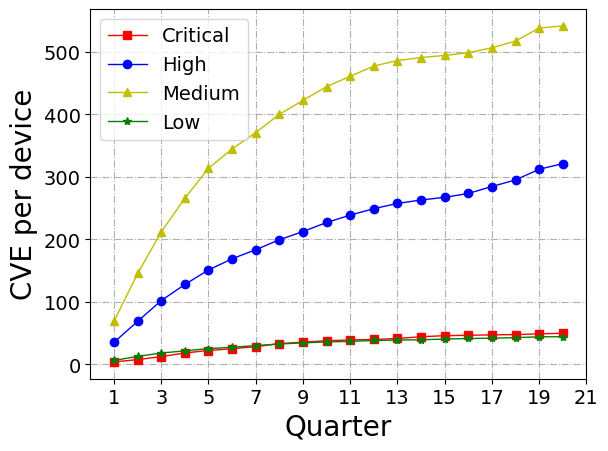

critical_per_pair_accumulated     33.733763
high_per_pair_accumulated        211.789534
medium_per_pair_accumulated      399.720357
low_per_pair_accumulated          32.616299
dtype: float64


,critical_per_pair_accumulated,high_per_pair_accumulated,medium_per_pair_accumulated,low_per_pair_accumulated
period,,,,
1,3.929421,35.224538,69.163402,6.264689
2,7.625207,68.834200,145.342674,12.800806
3,12.434614,102.006869,211.771797,18.134468
4,18.255187,127.786229,265.634505,21.642426
5,22.187711,150.923475,313.534342,25.128520
6,25.018076,168.893757,344.426572,27.389043
7,28.351589,183.307889,370.578927,30.044897
8,33.160831,199.258811,399.732966,32.597109
9,35.544752,212.332387,422.109695,34.405149


<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt


df_plot = df_quarters[df_quarters['period'] < 21][['period','critical_per_pair_accumulated','high_per_pair_accumulated','medium_per_pair_accumulated','low_per_pair_accumulated']]

df_plot.set_index('period',inplace=True)
styles = ['rs-','bo-','y^-','g*-']
df_plot.plot(style=styles,linewidth=1)
plt.xlabel('Quarter',fontsize=20)
plt.ylabel('CVE per device',fontsize=20)
plt.xticks(list(range(1, 22, 2)),list(range(1, 22, 2)),fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='-.')
plt.legend(['Critical','High','Medium','Low'],fontsize=14,loc=2)
plt.xlim(0, 21)
plt.savefig('../2024_Data/Figures/unsupported_severity.png', bbox_inches='tight')
plt.show()
plt.tight_layout()

print(df_plot.mean())

df_plot

In [31]:
df_plot['critical_per_pair_accumulated']+df_plot['high_per_pair_accumulated']+df_plot['medium_per_pair_accumulated']+df_plot['low_per_pair_accumulated']


period
1     114.582051
2     234.602887
3     344.347749
4     433.318347
5     511.774048
6     565.727447
7     612.283302
8     664.749718
9     704.391982
10    744.629756
11    775.002503
12    803.967239
13    823.408267
14    836.937016
15    847.395633
16    859.471469
17    879.644912
18    902.248864
19    942.570039
20    956.145817
dtype: float64

## User Interaction

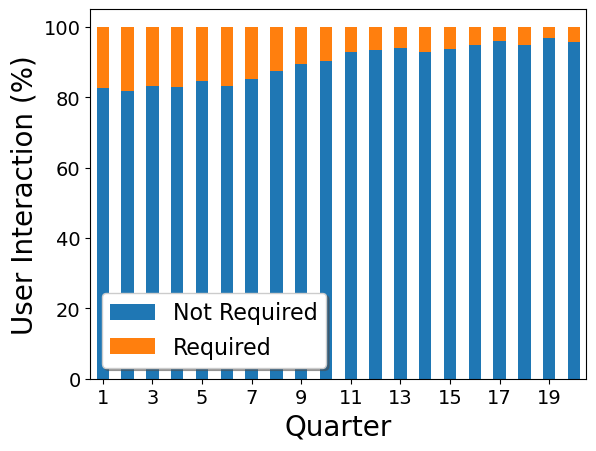

none_per        89.736076
required_per    10.263924
dtype: float64


,none_per,required_per
period,,
1,82.515809,17.484191
2,81.819769,18.180231
3,83.094504,16.905496
4,82.766706,17.233294
5,84.706630,15.293370
6,83.049385,16.950615
7,85.046943,14.953057
8,87.546567,12.453433
9,89.463107,10.536893


<Figure size 640x480 with 0 Axes>

In [32]:
df_plot = df_quarters[df_quarters['period'] < 21][['period','none_per','required_per']]
df_plot.set_index('period',inplace=True)

df_plot.plot(kind='bar',stacked=True)
plt.xlabel('Quarter',fontsize=20)
plt.ylabel('User Interaction (%)',fontsize=20)
plt.xticks(fontsize=14,rotation = 0)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.legend(['Not Required','Required'],fontsize=16,loc=3,shadow=True)
plt.savefig('../2024_Data/Figures/unsupported_user_interaction.png', bbox_inches='tight')
plt.show()
plt.tight_layout()

print(df_plot.mean())

df_plot

## Attack Complexity

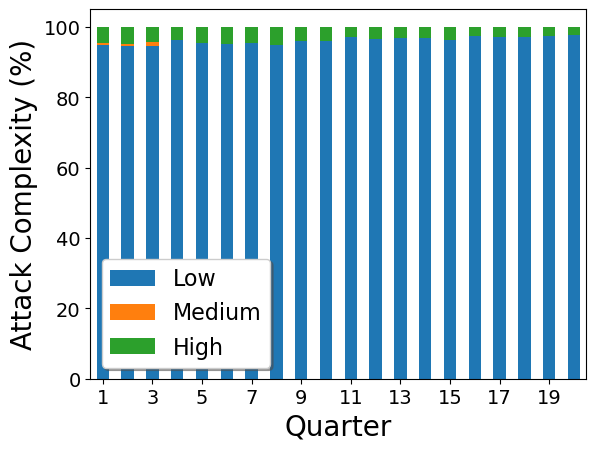

low_comp_per       96.151265
medium_comp_per     0.109563
high_comp_per       3.739172
dtype: float64


,low_comp_per,medium_comp_per,high_comp_per
period,,,
1,94.718851,0.615279,4.665869
2,94.638491,0.523926,4.837583
3,94.576456,1.052059,4.371486
4,96.170379,0.000000,3.829621
5,95.361152,0.000000,4.638848
6,95.169290,0.000000,4.830710
7,95.351500,0.000000,4.648500
8,94.944119,0.000000,5.055881
9,96.037898,0.000000,3.962102


<Figure size 640x480 with 0 Axes>

In [33]:
df_plot = df_quarters[df_quarters['period'] < 21][['period','low_comp_per','medium_comp_per','high_comp_per']]

df_plot.set_index('period',inplace=True)
hatches = ["*", "/", "o", "x"]

bars = df_plot.plot(kind='bar',stacked=True)
plt.xlabel('Quarter',fontsize=20)
plt.ylabel('Attack Complexity (%)',fontsize=20)
plt.xticks(fontsize=14,rotation = 0)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.legend(['Low','Medium','High'],fontsize=16,loc=3,shadow=True)
plt.savefig('../2024_Data/Figures/unsupported_attack_complexity.png', bbox_inches='tight')
plt.show()
plt.tight_layout()

print(df_plot.mean())

df_plot

## Attack Vector

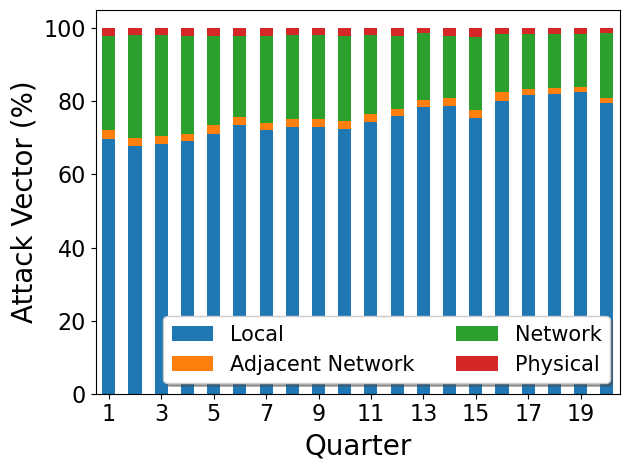

local_per               74.988791
adjacent_network_per     1.997190
network_per             21.148710
physical_per             1.865309
dtype: float64


In [34]:
import matplotlib.pyplot as plt

df_plot = df_quarters[df_quarters['period'] < 21][['period', 'local_per', 'adjacent_network_per', 'network_per', 'physical_per']]
df_plot.set_index('period', inplace=True)
df_plot.plot(kind='bar', stacked=True)

plt.xlabel('Quarter', fontsize=20)
plt.ylabel('Attack Vector (%)', fontsize=20)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.legend(['Local', 'Adjacent Network', 'Network', 'Physical'], fontsize=15, loc='lower right', ncol=2, shadow=True)
plt.tight_layout()

plt.savefig('../2024_Data/Figures/unsupported_attack_vector.png', bbox_inches='tight')
plt.show()

print(df_plot.mean())
